# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

E:\anaconda\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [2]:
#from google.colab import drive
#drive.mount('/content/gdrive')

In [3]:
# using SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 


filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 """, con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (525814, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [4]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [5]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B007Y59HVM,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ET0,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B007Y59HVM,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ET0,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBE1U,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [6]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B006P7E5ZI,"undertheshrine ""undertheshrine""",1334707200,5,I was recommended to try green tea extract to ...,5


In [7]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [8]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [9]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [10]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(364173, 10)

In [11]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

69.25890143662969

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [12]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [13]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [14]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)
final = final.sample(100000
                    )

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(364171, 10)


1    84425
0    15575
Name: Score, dtype: int64

In [15]:
final = final.sort_values('Time',ascending = True)#sorting by time for time series cross validation
final.shape

(100000, 10)

In [16]:
final.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
138683,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,1,940809600,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...
417839,451856,B00004CXX9,AIUWLEQ1ADEG5,Elizabeth Medina,0,0,1,944092800,Entertainingl Funny!,Beetlejuice is a well written movie ..... ever...
346055,374359,B00004CI84,A344SMIA5JECGM,Vincent P. Ross,1,2,1,944438400,A modern day fairy tale,"A twist of rumplestiskin captured on film, sta..."
346116,374422,B00004CI84,A1048CYU0OV4O8,Judy L. Eans,2,2,1,947376000,GREAT,THIS IS ONE MOVIE THAT SHOULD BE IN YOUR MOVIE...
346141,374450,B00004CI84,ACJR7EQF9S6FP,Jeremy Robertson,2,3,1,951523200,Bettlejuice...Bettlejuice...BETTLEJUICE!,What happens when you say his name three times...


#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [17]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

I can remember seeing the show when it aired on television years ago, when I was a child.  My sister later bought me the LP (which I have to this day,  I'm thirty something).I used this series of books &amp; songs when I did my  student teaching for preschoolers &amp; turned the whole school on to it.  I am now purchasing it on CD, along with the books for my children 5 &amp;  2.  The tradition lives on!
Frank's Red Hot sauce is the best hot sauce there is.  It's good on just about anything - even Chinese food!<br /><br />Seriously, try it on everything!  It gives anything a really great flavor & kick.
I purchased these on the special Friday sale where they were $7.99 for 3 cans. At the store where I normally shop here one can is almost $5 so this was a fantastic deal. I liked how they were lightly salted and not as salty as alot of nuts are.<br /><br />I agree with the other review that they were mostly almonds. Id say 60% almonds, 30% cashews and 10% macadamias but they were still qu

In [18]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

I can remember seeing the show when it aired on television years ago, when I was a child.  My sister later bought me the LP (which I have to this day,  I'm thirty something).I used this series of books &amp; songs when I did my  student teaching for preschoolers &amp; turned the whole school on to it.  I am now purchasing it on CD, along with the books for my children 5 &amp;  2.  The tradition lives on!


In [19]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

I can remember seeing the show when it aired on television years ago, when I was a child.  My sister later bought me the LP (which I have to this day,  I'm thirty something).I used this series of books & songs when I did my  student teaching for preschoolers & turned the whole school on to it.  I am now purchasing it on CD, along with the books for my children 5 &  2.  The tradition lives on!
Frank's Red Hot sauce is the best hot sauce there is.  It's good on just about anything - even Chinese food!Seriously, try it on everything!  It gives anything a really great flavor & kick.
I purchased these on the special Friday sale where they were $7.99 for 3 cans. At the store where I normally shop here one can is almost $5 so this was a fantastic deal. I liked how they were lightly salted and not as salty as alot of nuts are.I agree with the other review that they were mostly almonds. Id say 60% almonds, 30% cashews and 10% macadamias but they were still quite good.
This is the second time th

In [20]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [21]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

I purchased these on the special Friday sale where they were $7.99 for 3 cans. At the store where I normally shop here one can is almost $5 so this was a fantastic deal. I liked how they were lightly salted and not as salty as alot of nuts are.<br /><br />I agree with the other review that they were mostly almonds. Id say 60% almonds, 30% cashews and 10% macadamias but they were still quite good.


In [22]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

I can remember seeing the show when it aired on television years ago, when I was a child.  My sister later bought me the LP (which I have to this day,  I'm thirty something).I used this series of books &amp; songs when I did my  student teaching for preschoolers &amp; turned the whole school on to it.  I am now purchasing it on CD, along with the books for my children  &amp;    The tradition lives on!


In [23]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

I purchased these on the special Friday sale where they were 7 99 for 3 cans At the store where I normally shop here one can is almost 5 so this was a fantastic deal I liked how they were lightly salted and not as salty as alot of nuts are br br I agree with the other review that they were mostly almonds Id say 60 almonds 30 cashews and 10 macadamias but they were still quite good 


In [24]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [25]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|████████████████████████████████████████████████████████████████████████| 100000/100000 [00:42<00:00, 2374.83it/s]


In [26]:
#loading pickle for saving and retreiving files
import pickle
def savetofile(obj,filename):
    pickle.dump(obj,open(filename+".p","wb"))
def openfromfile(filename):
    temp = pickle.load(open(filename+".p","rb"))
    return temp

In [27]:
preprocessed_reviews[16]

'spectra paste food colors simply fantastic provide depth clarity color impossible achieve liquid food colors hues beautiful distinctive black red two colors difficult get dying frostings etc especially nice probably best manufacturer tried questions not certain sizes set mine bottles ounce might not seem like much need dot thick gel paste end toothpick color large amounts material plenty coloring ability bottle many many times sized liquid food color bottle highly recommended really good price time review'

# Splitting the data

In [28]:
from sklearn.model_selection import train_test_split

X_train,X_test,Y_train,Y_test = train_test_split(preprocessed_reviews,final['Score'],test_size=0.3)
#splitting the dataset 

print('Size of train dataset is:',len(X_train))#size of training dataset 
print('Size of the test dataset is:',len(X_test))#size of test dataset

Size of train dataset is: 70000
Size of the test dataset is: 30000


In [29]:
from sklearn.model_selection import TimeSeriesSplit#importing for time series split
tscv = TimeSeriesSplit(n_splits=10)#time series split for the data
print(tscv)

TimeSeriesSplit(n_splits=10)


In [30]:
from sklearn.model_selection import TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=10)
for train, cv in tscv.split(X_train):
    print('train data shape:',train.shape,'test data shape',cv.shape)

train data shape: (6370,) test data shape (6363,)
train data shape: (12733,) test data shape (6363,)
train data shape: (19096,) test data shape (6363,)
train data shape: (25459,) test data shape (6363,)
train data shape: (31822,) test data shape (6363,)
train data shape: (38185,) test data shape (6363,)
train data shape: (44548,) test data shape (6363,)
train data shape: (50911,) test data shape (6363,)
train data shape: (57274,) test data shape (6363,)
train data shape: (63637,) test data shape (6363,)


# [5] Applying Random forest

## [5.1] Applying Random Forests on BOW with RandomizedSearch CROSS VALIDATION,<font color='red'> SET 1</font>

In [51]:
bow_vect = CountVectorizer()#initiating the vectorizer

bow_vect.fit(X_train)#fitting data into vectorizer makes it learn all the vocablury

#transforming the data into training and test dataset
train_set_bow = bow_vect.transform(X_train)
test_set_bow = bow_vect.transform(X_test)

print('AFTER VECTORIZATION:')
print(train_set_bow.shape)
print(test_set_bow.shape)
print('Some of the feature names are:',bow_vect.get_feature_names()[:10:-1])


AFTER VECTORIZATION:
(70000, 50810)
(30000, 50810)


Some of the feature names are: ['zzzzzzzz', 'zzzzzzz', 'zzzzzz', 'zzz', 'zzigae', 'zz', 'zyrtec', 'zylitol', 'zyliss', 'zydeco', 'zwieback', 'zweiback', 'zurich', 'zupreem', 'zumba', 'zulu', 'zukes', 'zuke', 'zuk', 'zujirushi', 'zuchini', 'zuccini', 'zucchini', 'zuc', 'zsweet', 'zshop', 'zp', 'zowwie', 'zowie', 'zout', 'zours', 'zotz', 'zorroz', 'zoooooooooooom', 'zoonotic', 'zoomed', 'zoombies', 'zoom', 'zoo', 'zonkers', 'zones', 'zone', 'zon', 'zomg', 'zombies', 'zombieoid', 'zombie', 'zola', 'zoku', 'zojirushi', 'zoji', 'zoey', 'zoe', 'zo', 'zloty', 'ziyad', 'ziwipeak', 'ziwi', 'zits', 'ziti', 'zirconium', 'zirconia', 'ziptop', 'zips', 'zippy', 'zipping', 'zippers', 'zippered', 'zipper', 'zipped', 'ziplok', 'ziplocs', 'ziplocks', 'ziplock', 'ziploc', 'zipfizz', 'zipcar', 'zip', 'zioo', 'zion', 'zinnias', 'zinneas', 'zingy', 'zings', 'zinging', 'zingers', 'zinger', 'zing', 'zinfindel', 'zinfandels', 'zinfandel', 'zinczenko', 'zinc', 'zin', 'zimmern', 'zimmerman', 'zillions', 'zillion

In [52]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

estimators = [10,50,100,250,450]#list of estimators that will be tuned
depths = [3,9,11,15,50]#tuning depth to avoid overfitting and underfitting

params = {'max_depth':depths,'n_estimators':estimators}#for passing as argument

tscv = TimeSeriesSplit(n_splits = 5)#initiating 5 time series splits for cross validation

model = RandomizedSearchCV(RandomForestClassifier(bootstrap = True,criterion = 'gini',max_features = 'auto'),param_distributions = params,cv = tscv,verbose=1,scoring = 'roc_auc',
                           return_train_score=True,n_jobs = -1)
#fitting the classifier
#fitting the parameter distribution


model.fit(train_set_bow,Y_train)



Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 10.4min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed: 30.5min finished


RandomizedSearchCV(cv=TimeSeriesSplit(n_splits=5), error_score='raise',
          estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False),
          fit_params={}, iid=True, n_iter=10, n_jobs=-1,
          param_distributions={'max_depth': [3, 9, 11, 15, 50], 'n_estimators': [10, 50, 100, 250, 450]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score=True, scoring='roc_auc', verbose=1)

In [53]:
savetofile(model,'model_bow_rf')#saving the model

In [54]:
model_bow_rf = openfromfile('model_bow_rf')#retreiving the model

In [55]:
# as we have two hyperaparameters to tune so we will plot heatmap and to show hyperparameters giving maximum AUC score
def plots(model):#function for plotting heatmaps
    
    print('Best Hyperparameters are:',model.best_params_)
    df = pd.DataFrame(model.cv_results_)#saving into the dataframe
    results = df.groupby(['param_n_estimators','param_max_depth']).min().unstack()[['mean_test_score',
                                                                                              'mean_train_score']]
    #groupby by number of estimators and maximum depth and unstacking mean train and test score 
    
    results = results.fillna(0.1)#imputing all null values by 0.1
    
    sns.set(font_scale = 1.2)
    fig, ax = plt.subplots(figsize=(20,10))#setting the font size
    plt.subplot(2,2,1)
    title_test = 'AUC score on test set VS max_depth, min_samples_split'
    fmt = 'png'
    sns.heatmap(results.mean_test_score, annot=True, fmt='.4g');#heatmap for test score
    plt.title(title_test);
    #plt.savefig('{title_test}.{fmt}', format=fmt, dpi=300);

    plt.subplot(2,2,2)
    title_train = 'AUC score on train set VS max_depth, min_samples_split'
    fmt = 'png'
    sns.heatmap(results.mean_train_score, annot=True, fmt='.4g');#heatmap for train score
    plt.title(title_train);
    #plt.savefig('{title_train}.{fmt}', format=fmt, dpi=300);

Best Hyperparameters are: {'n_estimators': 450, 'max_depth': 50}


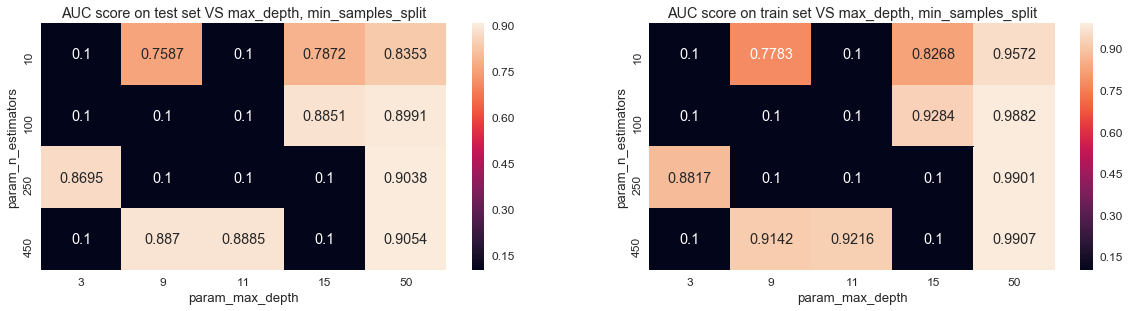

In [56]:
plots(model_bow_rf)

In [64]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from wordcloud import WordCloud
#from xgboost import XGBClassifier


#1.Function for calculating the test and train Area under curve after fitting with right hyperparameters
def auc(depth,estimator,train_set,test_set):
    tree_optimal = RandomForestClassifier(bootstrap = True,criterion = 'gini',max_depth = depth,n_estimators = estimator)
    tree_optimal.fit(train_set,Y_train)
    pred_tr = tree_optimal.predict(train_set)# predicting all the classes for test dataset for confusion matrix
    pred_test = tree_optimal.predict(test_set)#predicting all the classes for train dataset for confusin matrix
    
    train_pred_proba = tree_optimal.predict_proba(train_set)[:,1]
    test_pred_proba = tree_optimal.predict_proba(test_set)[:,1]
    #predict_proba gives the probability of a particular data point belonging to the specified class

    train_auc = roc_auc_score(Y_train,train_pred_proba)
    test_auc = roc_auc_score(Y_test,test_pred_proba)
    print('AUC on train data is:',train_auc)
    print('AUC on test data is:',test_auc)
    print("******************************************************\n")
    return train_auc,test_auc,train_pred_proba,test_pred_proba,pred_tr,pred_test


#*******************************************************************************************************************************    

#2.Function for plotting the roc curve
def curve(train_pred,test_pred ):
    fpr_tr, tpr_tr, _ = roc_curve(Y_train,train_pred)
    fpr_test, tpr_test, _ = roc_curve(Y_test,test_pred)
#calculating the fpr,tpr and thresholds for each training and test dataset
    auc_train = roc_auc_score(Y_train,train_pred)
    auc_test = roc_auc_score(Y_test, test_pred)
    sns.set_style('darkgrid')
    plt.figure(figsize=(8,8))
    plt.plot(np.linspace(0,1,100),np.linspace(0,1,100),"g--")#this plots the roc curve for AUC = 0.5
    plt.plot(fpr_tr,tpr_tr,'r',linewidth=2,label="train auc="+str(auc_train))
    plt.plot(fpr_test,tpr_test,'b',linewidth=1,label=" test auc="+str(auc_test))
    plt.xlabel('False positive rate(1-specificity)',fontsize=18)
    plt.ylabel('True positive rate(sensitivity)',fontsize=18)
    plt.title('Reciever operating characteristics curve',fontsize=18)
    plt.legend(loc='best')
    plt.show()
    print('**************************************\n')

#********************************************************************************************************************************

#3.Function for calculating F1,precision and recall
def metrics(pred):
    print('scores on test data are:\n')
    # calculating the precison score
    print('precison score is {}'.format(precision_score(Y_test,pred)))
    #calculating the recall score 
    print('\nrecall_score is {}'.format(recall_score(Y_test,pred)))
    #calculating the f1 score
    print('\nf1 score is {}\n'.format(f1_score(Y_test,pred)))
    print("****************************************************************\n")
    
#********************************************************************************************************************************

#4.Function for plotting the confusion matrix
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    
    A =(((C.T)/(C.sum(axis=1))).T)#for recall matrix
    
    B =(C/C.sum(axis=0))#for precision matrix
    plt.figure(figsize=(20,4))
    
    labels = [0,1]
    # representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()
#***************************************************************************************************************************** 
def features_and_wc(depth,estimator,train_set,vectorizer):
    text = "" #saving strings
    tree_optimal = RandomForestClassifier(criterion = 'gini',max_depth = depth,n_estimators = estimator)
    #tree_optimal = XGBClassifier(learning_rate = 0.1,booster = "gbtree",max_depth = depth,n_estimators = estimator)
    tree_optimal.fit(train_set,Y_train)
    features = tree_optimal.feature_importances_
    indices = np.argsort(features)[::-1]
    feature_names = vectorizer.get_feature_names()
    print('TOP 20 important features which gives maximum information gain on splitting are:\n')
    for i in (indices[0:20]):
        text = text + " " + feature_names[i]
        print("%s\t -->\t%f  "%(feature_names[i],features[i]))
     
    wordcloud = WordCloud(width=1500, height=600,stopwords = stopwords).generate(text) 
    # plot the WordCloud image  
    plt.figure(figsize = (30,8)) 
    plt.imshow(wordcloud, interpolation="bilinear") 
    plt.axis("off") 
    plt.margins(x=0, y=0) 
    plt.show() 
     
    

Here 0.1 signifies that set of parameters from the list were not used for tuning in randomized serach cv

In [70]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

## ROC and Confusion Matrix

In [65]:
best_depth_bow_rf = model_bow_rf.best_params_['max_depth']
best_n_bow_rf= model_bow_rf.best_params_['n_estimators']

AUC on train data is: 0.840513081825
AUC on test data is: 0.499790016193
******************************************************



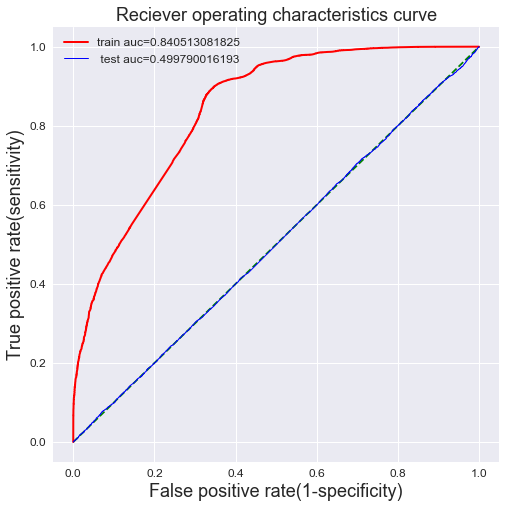

**************************************

scores on test data are:

precison score is 0.8433

recall_score is 1.0

f1 score is 0.9149894211468561

****************************************************************

Confusin matrix on train data


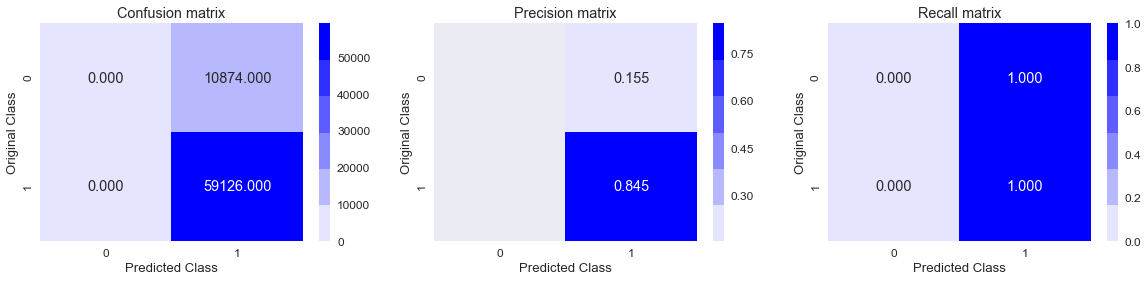

Confusion matrix for test data


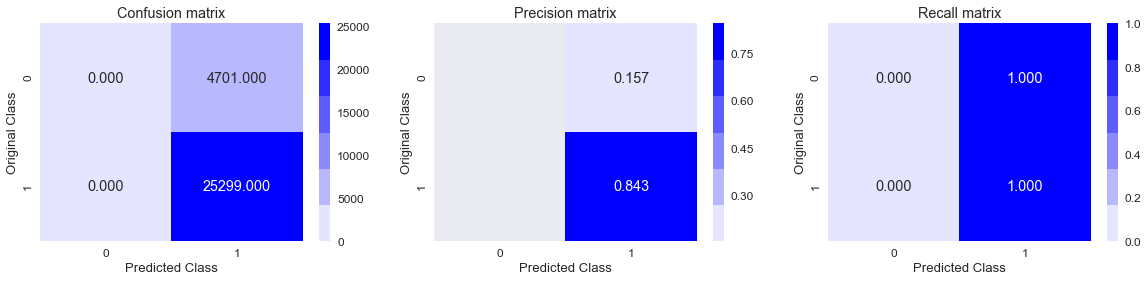

In [66]:
'''AUC ON TEST DATA'''
train_auc_BOW_rf,test_auc_BOW_rf,train_pred_proba,test_pred_proba,train_pred,test_pred = auc(best_depth_bow_rf,best_n_bow_rf,train_bow,test_bow)

'''PLOTTING THE ROC CURVE'''
curve(train_pred_proba,test_pred_proba)

'''Precision,recall and f1 score'''
metrics(test_pred)



'''Plotting the confusion matrix'''
print('Confusin matrix on train data')
plot_confusion_matrix(Y_train,train_pred)
print('Confusion matrix for test data')
plot_confusion_matrix(Y_test,test_pred)

# Feature Importance and WORDCLOUD

TOP 20 important features which gives maximum information gain on splitting are:

nota	 -->	0.002619  
cuantro	 -->	0.001636  
baily	 -->	0.001557  
resulyed	 -->	0.001541  
ligtly	 -->	0.001520  
cassava	 -->	0.001496  
graphic	 -->	0.001443  
goth	 -->	0.001434  
procyanidins	 -->	0.001418  
grimaced	 -->	0.001315  
tap	 -->	0.001277  
dependents	 -->	0.001249  
nanak	 -->	0.001243  
omission	 -->	0.001219  
smothering	 -->	0.001210  
girft	 -->	0.001183  
flo	 -->	0.001142  
chinsy	 -->	0.001134  
woould	 -->	0.001129  
nodding	 -->	0.001110  


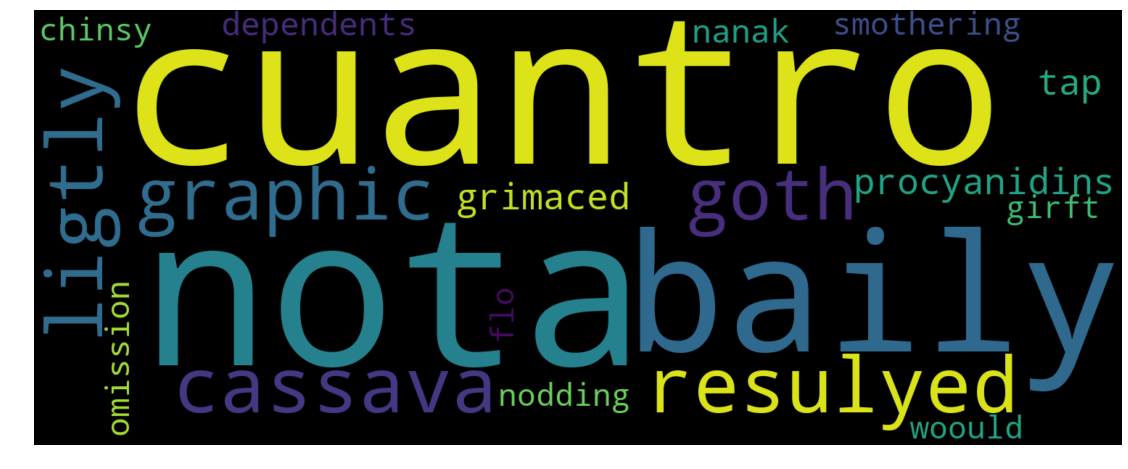

In [69]:
"""Most important features"""
features_and_wc(best_depth_bow_rf,best_n_bow_rf,train_bow,bow_vect)

## [5.2] Applying Random Forests on TFIDF,<font color='red'> SET 2</font>

In [0]:
# Please write all the code with proper documentation
tfidf_vect  = TfidfVectorizer(ngram_range = (1,2),min_df = 10)
#min_df signifies minimum number of times a word must occur in corpus for consideration
#ngram_range tells about the unigram and bigram
tfidf_vect.fit(X_train)
train_set = tfidf_vect.transform(X_train)
test_set = tfidf_vect.transform(X_test)

print('after vectorization training set:',train_set.shape)
print('after vectorization test set:',test_set.shape)


after vectorization training set: (70000, 40504)
after vectorization test set: (30000, 40504)


In [0]:
savetofile(train_set,'train_tfidf')#saving to file for future use
savetofile(test_set,'test_tfidf')

In [71]:
train_tfidf = openfromfile('computed/train_tfidf')
test_tfidf = openfromfile('computed/test_tfidf')

In [0]:

estimators = [10,50,100,250,450]#list of estimators that will be tuned
depths = [3,9,11,15,50]#tuning depth to avoid overfitting and underfitting

params = {'max_depth':depths,'n_estimators':estimators}#for passing as argument

tscv = TimeSeriesSplit(n_splits = 5)#initiating 5 time series splits for cross validation

model = RandomizedSearchCV(RandomForestClassifier(bootstrap = True,criterion = 'gini',max_features = 'auto'),param_distributions = params,cv = tscv,verbose=1,scoring = 'roc_auc',
                           return_train_score=True,n_jobs = -1)
#fitting the classifier
#fitting the parameter distribution


model.fit(train_tfidf,Y_train)



Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  4.5min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  5.0min finished


RandomizedSearchCV(cv=TimeSeriesSplit(n_splits=5), error_score='raise',
          estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False),
          fit_params={}, iid=True, n_iter=10, n_jobs=-1,
          param_distributions={'max_depth': [3, 9, 11, 15, 50], 'n_estimators': [10, 50, 100, 250, 450]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score=True, scoring='roc_auc', verbose=1)

In [0]:
savetofile(model,'model_tfidf_rf')

In [72]:
model_tfidf_rf = openfromfile('model_tfidf_rf')

Best Hyperparameters are: {'n_estimators': 250, 'max_depth': 50}


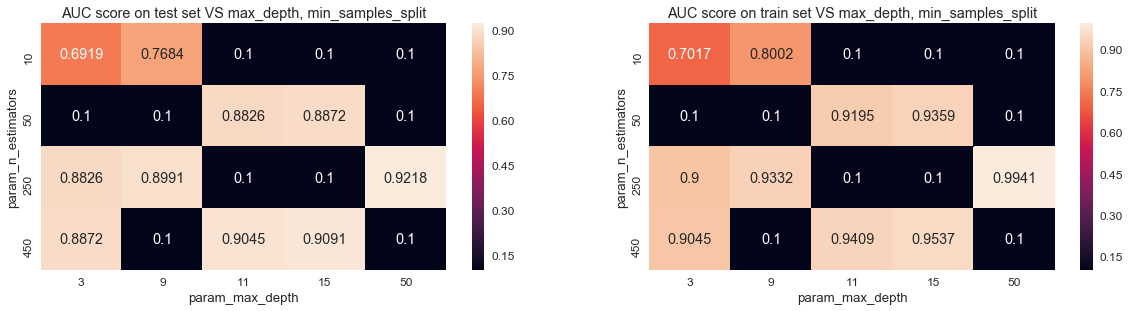

In [73]:
plots(model_tfidf_rf)

In [74]:
best_depth_tfidf_rf = model_tfidf_rf.best_params_['max_depth']#best depth of the decision trees
best_n_tfidf_rf = model_tfidf_rf.best_params_['n_estimators']#best number of decision tress

# ROC and Confusion Matrix

AUC on train data is: 0.84572698547
AUC on test data is: 0.495126376182
******************************************************



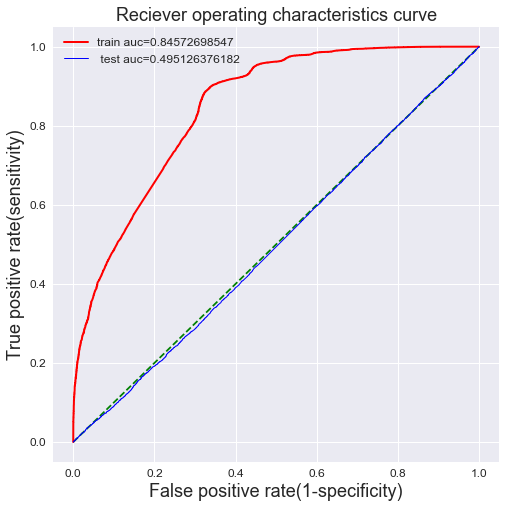

**************************************

scores on test data are:

precison score is 0.8433

recall_score is 1.0

f1 score is 0.9149894211468561

****************************************************************

Confusin matrix on train data


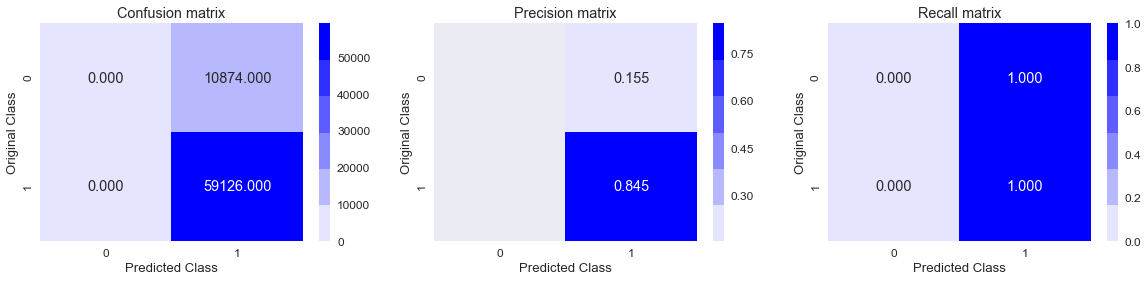

Confusion matrix for test data


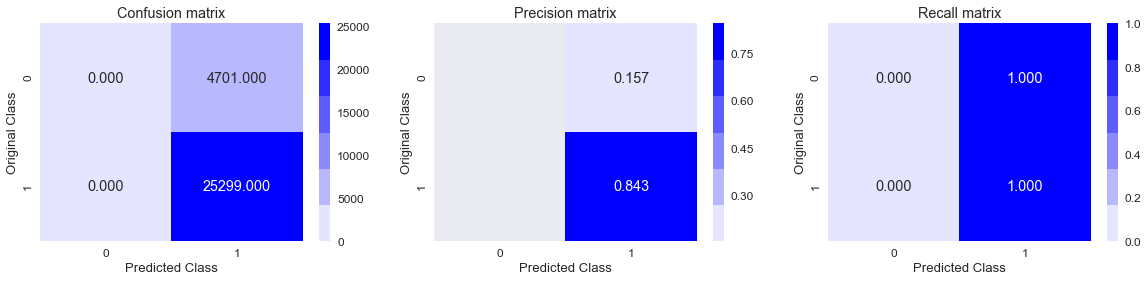

In [75]:
'''AUC ON TEST DATA'''
train_auc_tfidf_rf,test_auc_tfidf_rf,train_pred_proba,test_pred_proba,train_pred,test_pred = auc(best_depth_bow_rf,best_n_bow_rf,train_bow,test_bow)

'''PLOTTING THE ROC CURVE'''
curve(train_pred_proba,test_pred_proba)

'''Precision,recall and f1 score'''
metrics(test_pred)


'''Plotting the confusion matrix'''
print('Confusin matrix on train data')
plot_confusion_matrix(Y_train,train_pred)
print('Confusion matrix for test data')
plot_confusion_matrix(Y_test,test_pred)

# Feature importance and WORDCLOUD

TOP 20 important features which gives maximum information gain on splitting are:

not	 -->	0.016877  
great	 -->	0.011052  
disappointed	 -->	0.010158  
not buy	 -->	0.009911  
awful	 -->	0.009760  
worst	 -->	0.009393  
horrible	 -->	0.008511  
money	 -->	0.008419  
waste money	 -->	0.008219  
bad	 -->	0.008164  
waste	 -->	0.007668  
not recommend	 -->	0.006845  
disappointing	 -->	0.006349  
terrible	 -->	0.006257  
would not	 -->	0.006193  
best	 -->	0.006062  
threw	 -->	0.005787  
return	 -->	0.005548  
love	 -->	0.005523  
refund	 -->	0.005472  


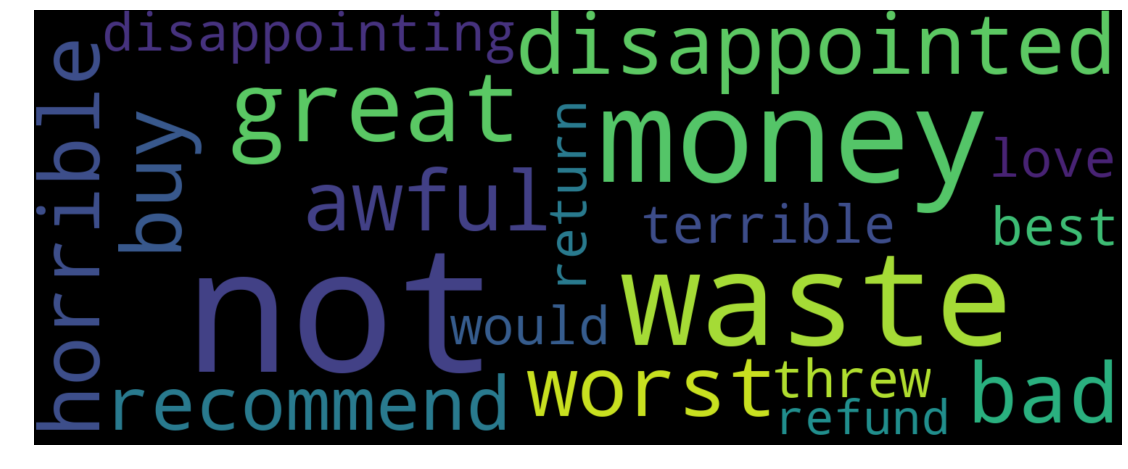

In [0]:
"""Most important features"""
features_and_wc(best_depth_tfidf_rf,best_n_tfidf_rf,train_tfidf,tfidf_vect)#for generating the wordcloud

## [5.3] Applying Random Forests on AVG W2V and TFIDF W2V,<font color='red'> SET 3</font>

In [0]:
s_train = []
for sent in X_train:
    s_train.append(sent.split())
#preparing the training data for  word to vector vectorization    
    
s_test = []
for sent in X_test:
    s_test.append(sent.split())
#preparing the test data for word to vector fatorization

In [0]:
# this line of code trains the w2v model on the give list of sentances   

w2v_model=Word2Vec(s_train,min_count=5,size=50, workers=4)# min_count = 5 considers only words that occured atleast 5 times

w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))


number of words that occured minimum 5 times  16003


In [0]:
print('sample words :',w2v_words[0:100])

sample words : ['four', 'cats', 'three', 'absolutely', 'love', 'treats', 'one', 'sometimes', 'accepts', 'however', 'ate', 'treat', 'would', 'not', 'touch', 'sniffed', 'walked', 'away', 'lovers', 'based', 'reaction', 'say', 'chance', 'cat', 'liking', 'pleased', 'delivery', 'product', 'expected', 'brach', 'mints', 'purchased', 'years', 'best', 'need', 'change', 'packaging', 'twist', 'ends', 'pressed', 'ease', 'taking', 'package', 'problem', 'made', 'mexico', 'usa', 'kraft', 'cheese', 'fill', 'blank', 'products', 'predictable', 'well', 'suited', 'young', 'palates', 'followed', 'box', 'recipe', 'two', 'changes', 'instead', 'chicken', 'flaked', 'oz', 'leftover', 'salmon', 'also', 'melted', 'half', 'dozen', 'slices', 'american', 'stronger', 'flavor', 'kid', 'friendly', 'unlike', 'frozen', 'broccoli', 'prominent', 'florets', 'tiny', 'dehydrated', 'reconstitute', 'much', 'failed', 'contribute', 'depending', 'eaters', 'may', 'consider', 'pro', 'con', 'hard', 'see', 'anybody', 'better', 'boxed']

##  [5.3.1] Average word to vector

In [0]:
#computing average word to vector for training data 
train_set = [] # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(s_train):
    sent_vec = np.zeros(50) 
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # 
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    train_set.append(sent_vec)

print(len(train_set))#number of data points

100%|███████████████████████████████████████████████████████████████████████████| 70000/70000 [02:23<00:00, 488.30it/s]


70000


In [0]:
#computing average word to vector for test data 

test_set = [] # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(s_test):
    sent_vec = np.zeros(50) 
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # 
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    test_set.append(sent_vec)

print(len(test_set))#number of datapoints in test set

100%|███████████████████████████████████████████████████████████████████████████| 30000/30000 [01:08<00:00, 440.16it/s]


30000


In [0]:
savetofile(train_set,'train_avgw2v')
savetofile(test_set,'test_avgw2v')

In [0]:
train_avgw2v = openfromfile('gdrive/My Drive/Colab Notebooks/computed/train_avgw2v')
test_avgw2v = openfromfile('gdrive/My Drive/Colab Notebooks/computed/test_avgw2v')


In [0]:
estimators = [10,50,100,250,450]#list of estimators that will be tuned
depths = [3,9,11,15,50]#tuning depth to avoid overfitting and underfitting
params = {'max_depth':depths,'n_estimators':estimators}#for passing as argument
tscv = TimeSeriesSplit(n_splits = 5)#initiating 5 time series splits for cross validation
model = RandomizedSearchCV(RandomForestClassifier(bootstrap = True,criterion = 'gini',max_features = 'auto'),param_distributions = params,cv = tscv,verbose=1,scoring = 'roc_auc',
                           return_train_score=True,n_jobs = -1)
#fitting the classifier
#fitting the parameter distribution
model.fit(train_avgw2v,Y_train)



Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  7.4min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed: 11.2min finished


RandomizedSearchCV(cv=TimeSeriesSplit(n_splits=5), error_score='raise',
          estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False),
          fit_params={}, iid=True, n_iter=10, n_jobs=-1,
          param_distributions={'max_depth': [3, 9, 11, 15, 50], 'n_estimators': [10, 50, 100, 250, 450]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score=True, scoring='roc_auc', verbose=1)

In [0]:
savetofile(model,'model_avgw2v_rf')

In [0]:
model_avgw2v_rf = openfromfile('model_avgw2v_rf')

Best Hyperparameters are: {'n_estimators': 250, 'max_depth': 15}


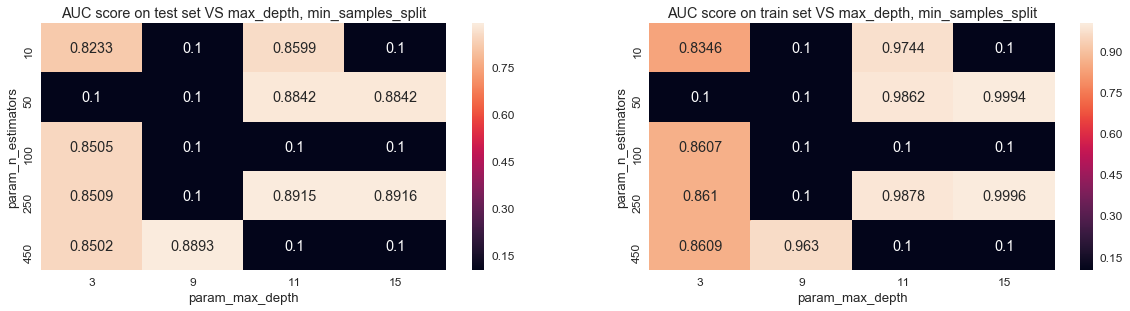

In [0]:
plots(model_avgw2v_rf)

# ROC and Confusion Matrix

AUC on train data is: 0.998923590696
AUC on test data is: 0.903633184442
******************************************************



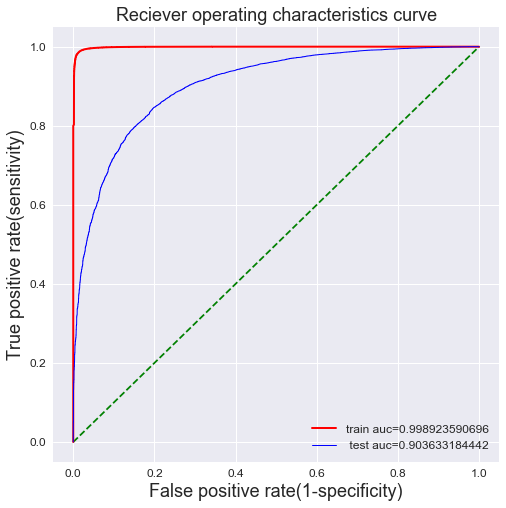

**************************************

scores on test data are:

precison score is 0.8898365569909357

recall_score is 0.9848724227822103

f1 score is 0.9349456317960255

****************************************************************

Confusin matrix on train data


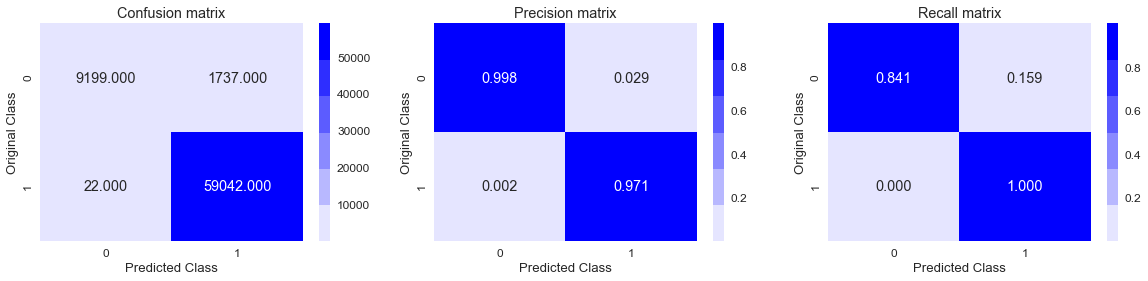

Confusion matrix for test data


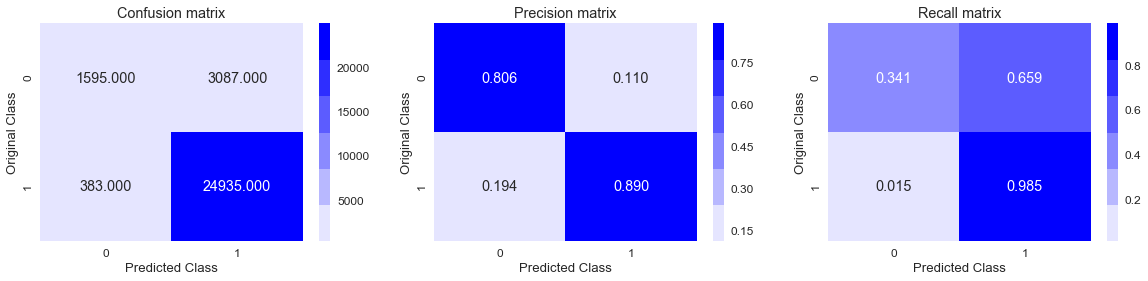

In [0]:
'''AUC ON TEST DATA'''
train_auc_avgw2v_rf,test_auc_avgw2v_rf,train_pred_proba,test_pred_proba,train_pred,test_pred = auc(best_depth_avgw2v_rf,best_n_avgw2v_rf,train_avgw2v,test_avgw2v)

'''PLOTTING THE ROC CURVE'''
curve(train_pred_proba,test_pred_proba)

'''Precision,recall and f1 score'''
metrics(test_pred)


'''Plotting the confusion matrix'''
print('Confusin matrix on train data')
plot_confusion_matrix(Y_train,train_pred)
print('Confusion matrix for test data')
plot_confusion_matrix(Y_test,test_pred)

## [5.3.2] Applying Random Forests on TFIDF W2V,<font color='red'> SET 4</font>

In [0]:
vect_tfidfw2v = TfidfVectorizer()#initializing the tfidf vectorizer 

tf_idf = vect_tfidfw2v.fit_transform(X_train)#fitting the training data
dictionary = dict(zip(vect_tfidfw2v.get_feature_names(), list(vect_tfidfw2v.idf_)))#zipping both of the feature names and vectorizer idf scores

In [0]:
import itertools
dict(itertools.islice(dictionary.items(),20))
#printing first 20 elements of the dictionary

{'aa': 9.5172074770284834,
 'aaa': 10.546826894209641,
 'aaaa': 11.463117626083797,
 'aaaaa': 11.463117626083797,
 'aaaaaa': 11.463117626083797,
 'aaaaaaaaaaaa': 11.463117626083797,
 'aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa': 11.463117626083797,
 'aaaaaahhhhhyaaaaaa': 11.463117626083797,
 'aaaaaand': 11.463117626083797,
 'aaaaah': 11.463117626083797,
 'aaaah': 11.057652517975633,
 'aaaand': 11.463117626083797,
 'aaaannnnddd': 11.463117626083797,
 'aaagh': 11.463117626083797,
 'aaah': 10.769970445523851,
 'aaahhh': 11.463117626083797,
 'aaahs': 11.463117626083797,
 'aadp': 11.463117626083797,
 'aafco': 10.076823264963906,
 'aafes': 10.769970445523851}

In [0]:
tfidf_feat = vect_tfidfw2v.get_feature_names() # tfidf words/col-names
print(tfidf_feat[:100])

['aa', 'aaa', 'aaaa', 'aaaaa', 'aaaaaa', 'aaaaaaaaaaaa', 'aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa', 'aaaaaahhhhhyaaaaaa', 'aaaaaand', 'aaaaah', 'aaaah', 'aaaand', 'aaaannnnddd', 'aaagh', 'aaah', 'aaahhh', 'aaahs', 'aadp', 'aafco', 'aafes', 'aafter', 'aah', 'aahhhs', 'aahing', 'aalouisiana', 'aanother', 'aap', 'aarrgh', 'aarti', 'ab', 'aback', 'abandon', 'abandoned', 'abandoning', 'abbey', 'abbott', 'abby', 'abc', 'abd', 'abdomen', 'abdominal', 'abduct', 'aber', 'abhor', 'abhorrent', 'abide', 'abiding', 'abietate', 'abig', 'abigirl', 'abiiity', 'abilities', 'ability', 'abit', 'abj', 'abject', 'abjectly', 'ablation', 'ablaze', 'able', 'abletate', 'ableto', 'ablsolutely', 'ably', 'abmout', 'abnormal', 'abnormalities', 'abnormally', 'abnoxious', 'abominable', 'abominably', 'abomination', 'abondant', 'aboout', 'aboslutely', 'abosolutely', 'abot', 'abottle', 'abou', 'abound', 'aboutamazon', 'abouthis', 'abouti', 'aboutits', 'aboutletting', 'aboutthis', 'aboutwhat', 'abouy', 'aboveour', 

In [0]:
train_set_tfidfw2v = []; # the tfidf-w2v for each sentence/review in training set is stored in this list
row=0;
for sent in tqdm(s_train): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    train_set_tfidfw2v.append(sent_vec)
    row += 1    
print(len(train_set_tfidfw2v))

100%|████████████████████████████████████████████████████████████████████████████| 70000/70000 [43:19<00:00, 23.53it/s]


70000


In [0]:
test_set_tfidfw2v = []; # the tfidf-w2v for each sentence/review in test set is stored in this list
row=0;
for sent in tqdm(s_test): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    test_set_tfidfw2v.append(sent_vec)
    row += 1
    
print(len(test_set_tfidfw2v))


100%|████████████████████████████████████████████████████████████████████████████| 30000/30000 [18:22<00:00, 27.21it/s]


30000


In [0]:
train_tfidfw2v = openfromfile('gdrive/My Drive/Colab Notebooks/computed/train_tfidfw2v')
test_tfidfw2v = openfromfile('gdrive/My Drive/Colab Notebooks/computed/test_tfidfw2v')

In [0]:
estimators = [10,50,100,250,450]#list of estimators that will be tuned
depths = [3,9,11,15,50]#tuning depth to avoid overfitting and underfitting
params = {'max_depth':depths,'n_estimators':estimators}#for passing as argument
tscv = TimeSeriesSplit(n_splits = 5)#initiating 5 time series splits for cross validation
model = RandomizedSearchCV(RandomForestClassifier(bootstrap = True,criterion = 'gini',max_features = 'auto'),param_distributions = params,cv = tscv,verbose=1,scoring = 'roc_auc',
                           return_train_score=True,n_jobs = -1)
#fitting the classifier
#fitting the parameter distribution
model.fit(train_tfidfw2v,Y_train)



Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 11.0min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed: 14.7min finished


RandomizedSearchCV(cv=TimeSeriesSplit(n_splits=5), error_score='raise',
          estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False),
          fit_params={}, iid=True, n_iter=10, n_jobs=-1,
          param_distributions={'max_depth': [3, 9, 11, 15, 50], 'n_estimators': [10, 50, 100, 250, 450]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score=True, scoring='roc_auc', verbose=1)

In [0]:
savetofile(model,'model_tfidfw2v_rf')

In [0]:
model_tfidfw2v_rf = openfromfile('model_tfidfw2v_rf')

Best Hyperparameters are: {'n_estimators': 450, 'max_depth': 50}


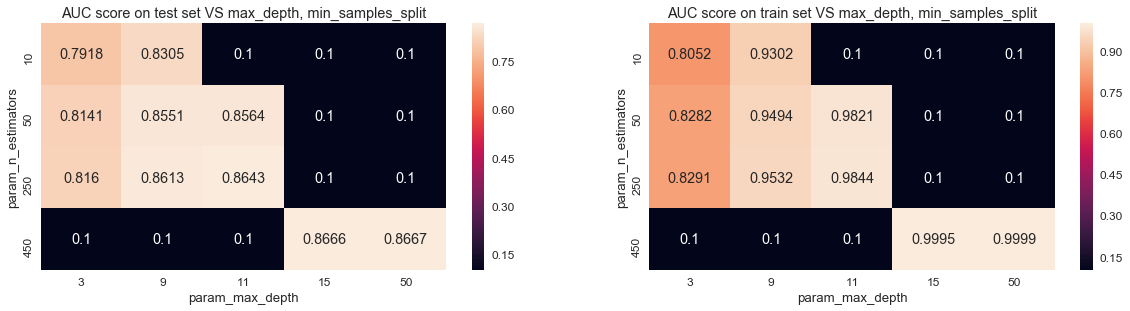

In [0]:
plots(model_tfidfw2v_rf)

In [0]:
best_depth_tfidfw2v_rf = model_tfidfw2v_rf.best_params_['max_depth']
best_n_tfidfw2v_rf = model_tfidfw2v_rf.best_params_['n_estimators']

AUC on train data is: 0.999805975597
AUC on test data is: 0.883013839274
******************************************************



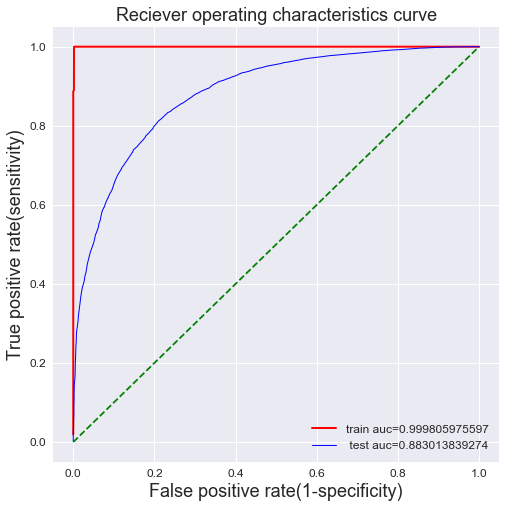

**************************************

scores on test data are:

precison score is 0.8792848595762652

recall_score is 0.9868078047239118

f1 score is 0.9299486339611404

****************************************************************

Confusin matrix on train data


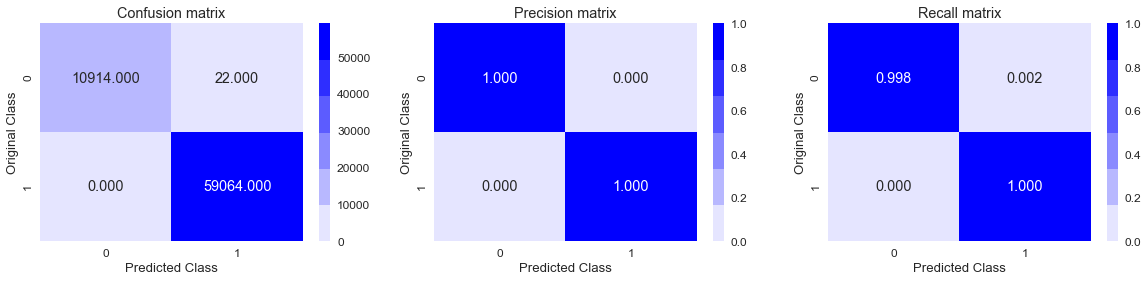

Confusion matrix for test data


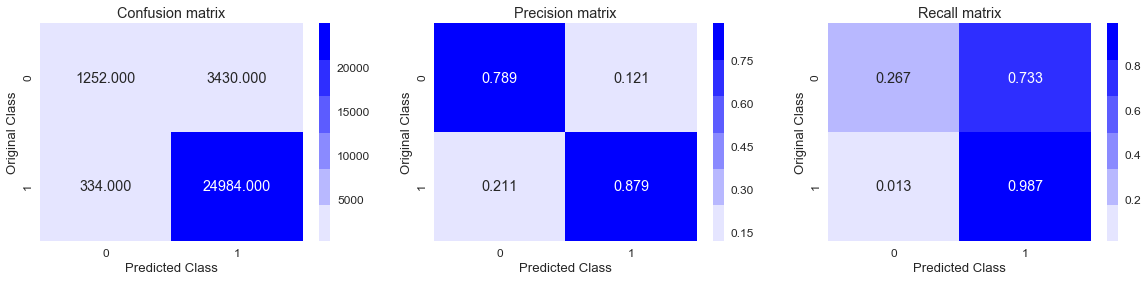

In [0]:
'''AUC ON TEST DATA'''
train_auc_tfidfw2v_rf,test_auc_tfidfw2v_rf,train_pred_proba,test_pred_proba,train_pred,test_pred = auc(best_depth_tfidfw2v_rf,best_n_tfidfw2v_rf,train_tfidfw2v,test_tfidfw2v)

'''PLOTTING THE ROC CURVE'''
curve(train_pred_proba,test_pred_proba)

'''Precision,recall and f1 score'''
-metrics(test_pred)


'''Plotting the confusion matrix'''
print('Confusin matrix on train data')
plot_confusion_matrix(Y_train,train_pred)
print('Confusion matrix for test data')
plot_confusion_matrix(Y_test,test_pred)

# [6] Applying GBDT using XGBOOST

## [6.1] Applying XGBOOST on BOW,<font color='red'> SET 1</font>

In [0]:
from xgboost import XGBClassifier
from sklearn.model_selection import  RandomizedSearchCV
from sklearn.model_selection import TimeSeriesSplit



estimators = [10,50,100,200,450]#list of estimators that will be tuned
depths = [3,9,11,13,15]#tuning depth to avoid overfitting and underfitting
params = {'max_depth':depths,'n_estimators':estimators}#for passing as argument

tscv = TimeSeriesSplit(n_splits = 5)
model = RandomizedSearchCV(XGBClassifier(booster = 'gbtree',learning_rate = 0.1),param_distributions = params,cv = tscv,verbose = 1,return_train_score = True)#initiating the classifier
model.fit(train_bow,Y_train)#fitting the model



Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed: 73.7min finished


RandomizedSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=5),
                   error_score='raise-deprecating',
                   estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                           colsample_bylevel=1,
                                           colsample_bynode=1,
                                           colsample_bytree=1, gamma=0,
                                           learning_rate=0.1, max_delta_step=0,
                                           max_depth=3, min_child_weight=1,
                                           missing=None, n_estimators=100,
                                           n_jobs=1, nthread=None,
                                           objective='binary:logistic',
                                           random_state=0, reg_alpha=0,
                                           reg_lambda=1, scale_pos_weight=1,
                                           seed=None, silent=None, subsample=1,
 

In [0]:
savetofile(model,'model_bow_gb')

In [0]:
model_bow_gb = openfromfile('model_bow_gb')

Best Hyperparameters are: {'n_estimators': 100, 'max_depth': 3}


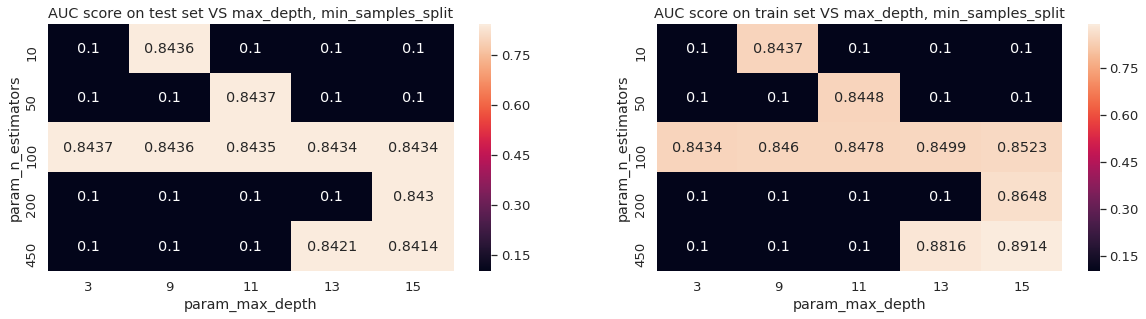

In [0]:
plots(model_bow_gb)

In [0]:
best_depth_bow_gb = model_bow_gb.best_params_['max_depth']
best_n_bow_gb = model_bow_gb.best_params_['n_estimators']

AUC on train data is: 0.589092490071771
AUC on test data is: 0.5008964517846474
******************************************************



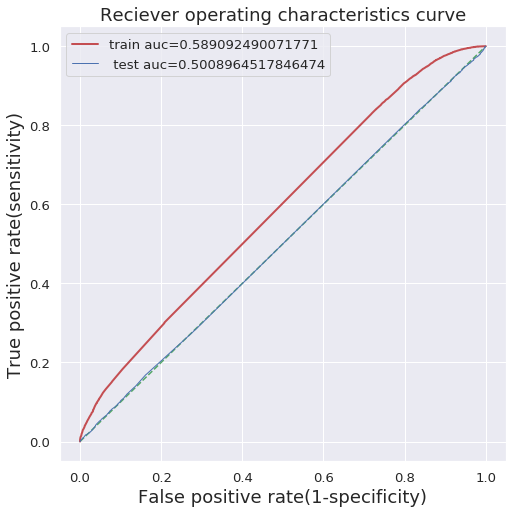

**************************************

scores on test data are:

precison score is 0.8429

recall_score is 1.0

f1 score is 0.9147539204514623

****************************************************************

Confusin matrix on train data


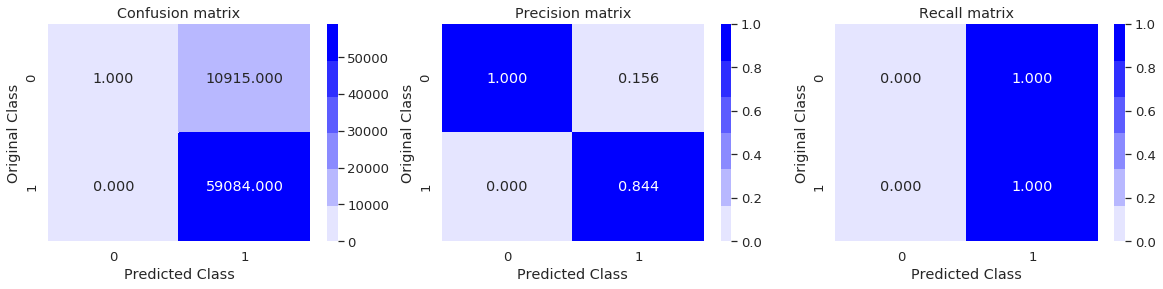

Confusion matrix for test data


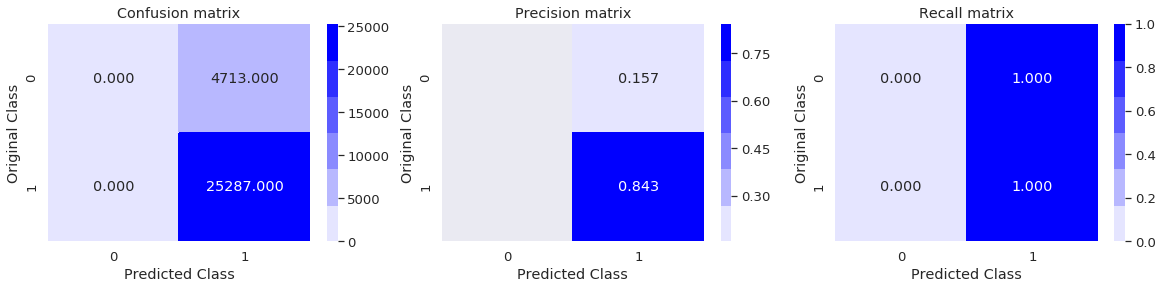

In [0]:
'''AUC ON TEST DATA'''
train_auc_bow_gb,test_auc_bow_gb,train_pred_proba,test_pred_proba,train_pred,test_pred = auc(best_depth_bow_gb,best_n_bow_gb,train_bow,test_bow)

'''PLOTTING THE ROC CURVE'''
curve(train_pred_proba,test_pred_proba)

'''Precision,recall and f1 score'''
metrics(test_pred)


'''Plotting the confusion matrix'''
print('Confusin matrix on train data')
plot_confusion_matrix(Y_train,train_pred)
print('Confusion matrix for test data')
plot_confusion_matrix(Y_test,test_pred)

TOP 20 important features which gives maximum information gain on splitting are:

dorms	 -->	0.007687  
fragments	 -->	0.007296  
packedand	 -->	0.007185  
flavorpineappleblue	 -->	0.007135  
steveia	 -->	0.006729  
wake	 -->	0.006622  
terra	 -->	0.006486  
wiskas	 -->	0.006415  
exited	 -->	0.006380  
example	 -->	0.006345  
stover	 -->	0.005949  
souther	 -->	0.005792  
returne	 -->	0.005623  
pricefor	 -->	0.005567  
slackened	 -->	0.005395  
tahari	 -->	0.005368  
disipate	 -->	0.005320  
verify	 -->	0.005293  
ribeyes	 -->	0.005286  
unheard	 -->	0.005201  


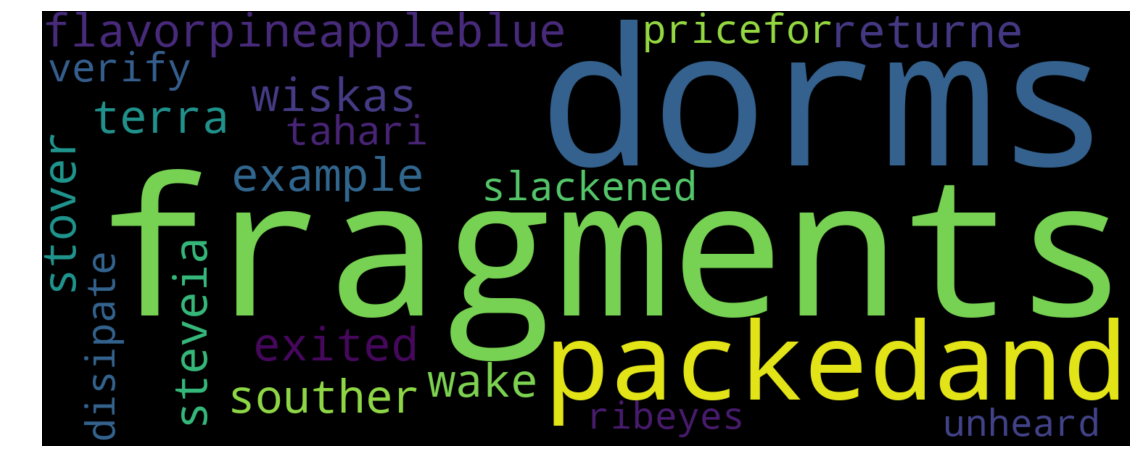

In [0]:
"""Most important features"""
features_and_wc(best_depth_bow_gb,best_n_bow_gb,train_bow,bow_vect)#for generating the wordcloud

## [6.2] Applying XGBOOST on TFIDF,<font color='red'> SET 2</font>

In [0]:

estimators = [10,50,100,200,450]#list of estimators that will be tuned
depths = [3,9,11,13,15]#tuning depth to avoid overfitting and underfitting
params = {'max_depth':depths,'n_estimators':estimators}#for passing as argument

tscv = TimeSeriesSplit(n_splits = 5)
model = RandomizedSearchCV(XGBClassifier(booster = 'gbtree',learning_rate = 0.1),param_distributions = params,cv = tscv,verbose = 1,return_train_score = True)#initiating the classifier
model.fit(train_tfidf,Y_train)#fitting the model



Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed: 96.0min finished


RandomizedSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=5),
                   error_score='raise-deprecating',
                   estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                           colsample_bylevel=1,
                                           colsample_bynode=1,
                                           colsample_bytree=1, gamma=0,
                                           learning_rate=0.1, max_delta_step=0,
                                           max_depth=3, min_child_weight=1,
                                           missing=None, n_estimators=100,
                                           n_jobs=1, nthread=None,
                                           objective='binary:logistic',
                                           random_state=0, reg_alpha=0,
                                           reg_lambda=1, scale_pos_weight=1,
                                           seed=None, silent=None, subsample=1,
 

In [0]:
savetofile(model,'model_tfidf_gb')

In [0]:
model_tfidf_gb = openfromfile('model_tfidf_gb')

Best Hyperparameters are: {'n_estimators': 200, 'max_depth': 3}


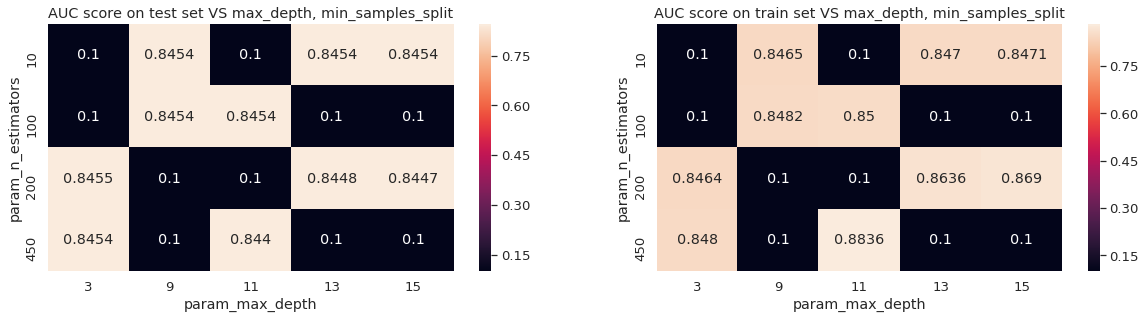

In [0]:
plots(model_tfidf_gb)#plotting for the model

In [0]:
best_depth_tfidf_gb = model_tfidf_gb.best_params_['max_depth']
best_n_tfidf_gb = model_tfidf_gb.best_params_['n_estimators']

AUC on train data is: 0.6329197824002808
AUC on test data is: 0.4984142110328607
******************************************************



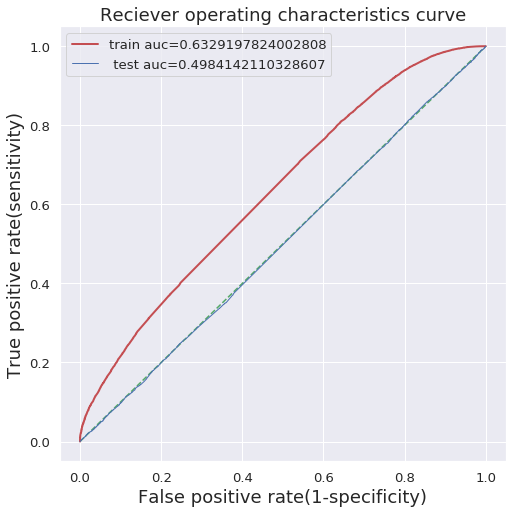

**************************************

scores on test data are:

precison score is 0.8386666666666667

recall_score is 1.0

f1 score is 0.9122552574329225

****************************************************************

Confusin matrix on train data


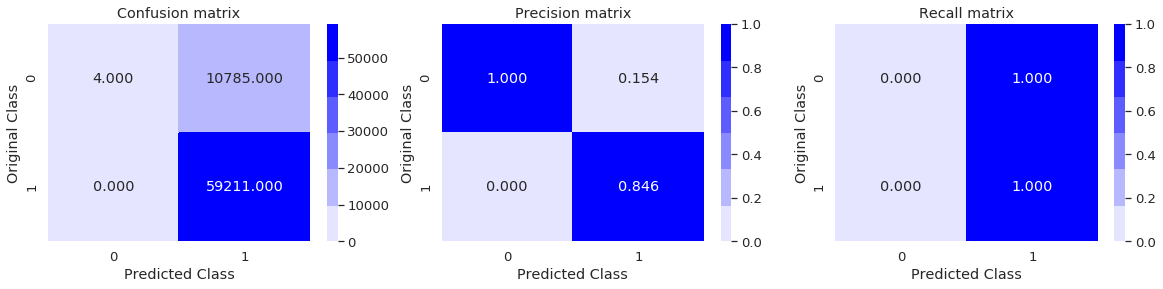

Confusion matrix for test data


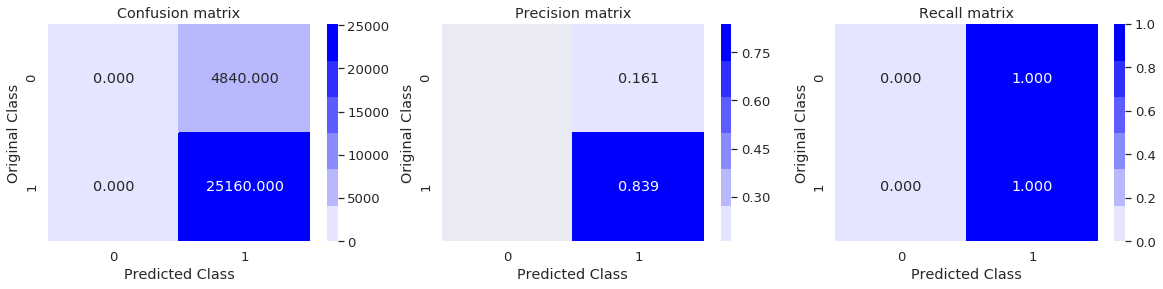

In [0]:
'''AUC ON TEST DATA'''
train_auc_tfidf_gb,test_auc_tfidf_gb,train_pred_proba,test_pred_proba,train_pred,test_pred = auc(best_depth_tfidf_gb,best_n_tfidf_gb,train_bow,test_bow)

'''PLOTTING THE ROC CURVE'''
curve(train_pred_proba,test_pred_proba)

'''Precision,recall and f1 score'''
metrics(test_pred)


'''Plotting the confusion matrix'''
print('Confusin matrix on train data')
plot_confusion_matrix(Y_train,train_pred)
print('Confusion matrix for test data')
plot_confusion_matrix(Y_test,test_pred)

## [6.3] Applying XGBOOST on AVG W2V,<font color='red'> SET 3</font>

In [42]:
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBClassifier
estimators = [10,50,100,200,450]#list of estimators that will be tuned
depths = [3,9,11,13,15]#tuning depth to avoid overfitting and underfitting
params = {'max_depth':depths,'n_estimators':estimators}#for passing as argument

tscv = TimeSeriesSplit(n_splits = 5)
model = RandomizedSearchCV(XGBClassifier(booster = 'gbtree',learning_rate = 0.1),param_distributions = params,cv = tscv,verbose = 1,return_train_score = True)#initiating the classifier
model.fit(np.array(train_avgw2v),Y_train)#fitting the model


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed: 46.9min finished


RandomizedSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=5),
                   error_score='raise-deprecating',
                   estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                           colsample_bylevel=1,
                                           colsample_bynode=1,
                                           colsample_bytree=1, gamma=0,
                                           learning_rate=0.1, max_delta_step=0,
                                           max_depth=3, min_child_weight=1,
                                           missing=None, n_estimators=100,
                                           n_jobs=1, nthread=None,
                                           objective='binary:logistic',
                                           random_state=0, reg_alpha=0,
                                           reg_lambda=1, scale_pos_weight=1,
                                           seed=None, silent=None, subsample=1,
 

In [0]:
savetofile(model,'model_avgw2v_gb')

In [0]:
model_avgw2v_gb = openfromfile('model_avgw2v_gb')

Best Hyperparameters are: {'n_estimators': 50, 'max_depth': 3}


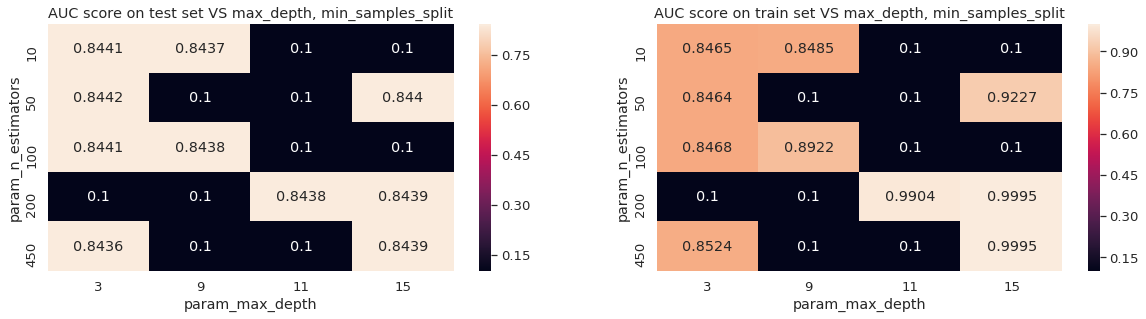

In [45]:
plots(model_avgw2v_gb)

In [0]:
best_depth_avgw2v_gb = model_avgw2v_gb.best_params_['max_depth']
best_n_avgw2v_gb = model_avgw2v_gb.best_params_['n_estimators']

AUC on train data is: 0.5544450279507798
AUC on test data is: 0.5021911936221565
******************************************************



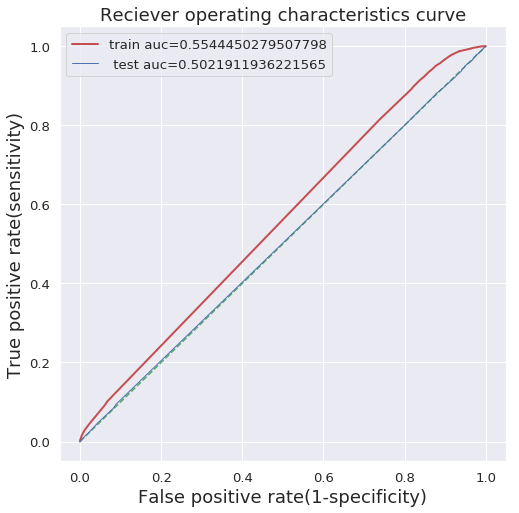

**************************************

scores on test data are:

precison score is 0.8421666666666666

recall_score is 1.0

f1 score is 0.9143219035555958

****************************************************************

Confusin matrix on train data


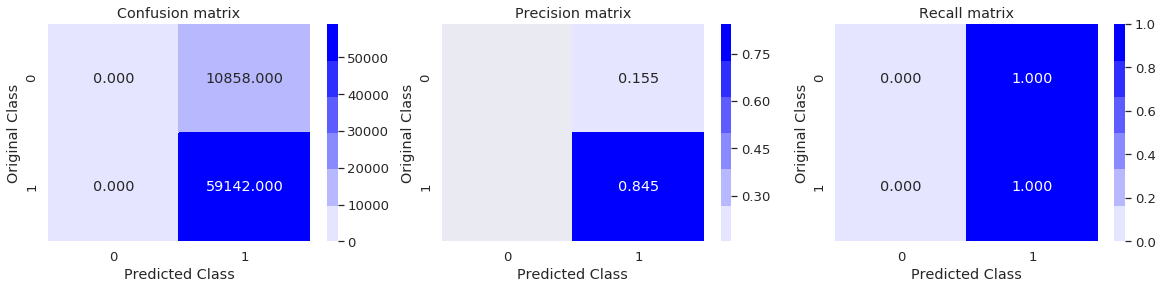

Confusion matrix for test data


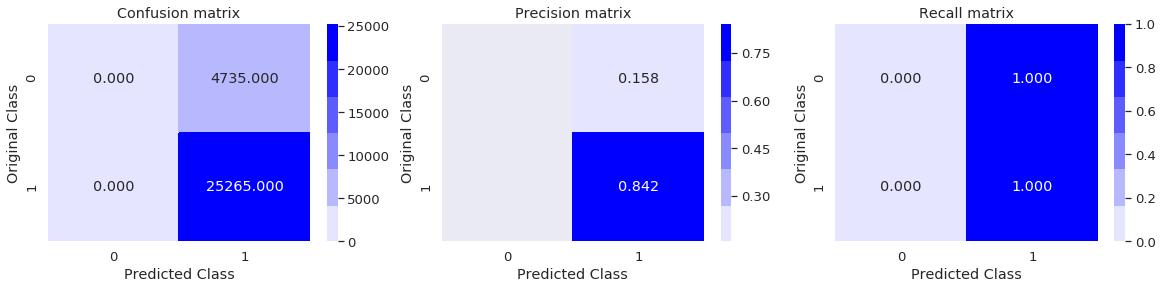

In [48]:
'''AUC ON TEST DATA'''
train_auc_avgw2v_gb,test_auc_avgw2v_gb,train_pred_proba,test_pred_proba,train_pred,test_pred = auc(best_depth_avgw2v_gb,best_n_avgw2v_gb,train_bow,test_bow)

'''PLOTTING THE ROC CURVE'''
curve(train_pred_proba,test_pred_proba)

'''Precision,recall and f1 score'''
metrics(test_pred)


'''Plotting the confusion matrix'''
print('Confusin matrix on train data')
plot_confusion_matrix(Y_train,train_pred)
print('Confusion matrix for test data')
plot_confusion_matrix(Y_test,test_pred)

## [6.4] Applying XGBOOST on TFIDF W2V,<font color='red'> SET 4</font>

In [32]:
train_tfidfw2v = openfromfile('computed/train_tfidfw2v')
test_tfidfw2v = openfromfile('computed/test_tfidfw2v')

In [33]:
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBClassifier

estimators = [10,50,100,200,450]#list of estimators that will be tuned
depths = [3,9,11,13,15]#tuning depth to avoid overfitting and underfitting
params = {'max_depth':depths,'n_estimators':estimators}#for passing as argument

tscv = TimeSeriesSplit(n_splits = 5)
model = RandomizedSearchCV(XGBClassifier(booster = 'gbtree',learning_rate = 0.1),param_distributions = params,cv = tscv,verbose = 1,return_train_score = True)#initiating the classifier
model.fit(np.array(train_tfidfw2v),Y_train)#fitting the model

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed: 128.9min finished


RandomizedSearchCV(cv=TimeSeriesSplit(n_splits=5), error_score='raise',
          estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
          fit_params={}, iid=True, n_iter=10, n_jobs=1,
          param_distributions={'max_depth': [3, 9, 11, 13, 15], 'n_estimators': [10, 50, 100, 200, 450]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score=True, scoring=None, verbose=1)

In [34]:
savetofile(model,'model_tfidfw2v_gb')

In [35]:
model_tfidfw2v_gb = openfromfile('model_tfidfw2v_gb')

Best Hyperparameters are: {'n_estimators': 10, 'max_depth': 3}


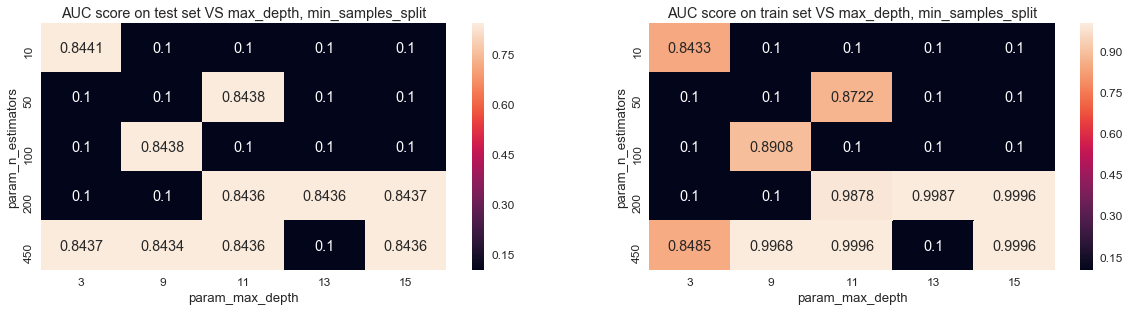

In [39]:
plots(model_tfidfw2v_gb)

In [55]:
best_depth_tfidfw2v_gb = model_tfidfw2v_gb.best_params_['max_depth']
best_n_tfidfw2v_gb = model_tfidfw2v_gb.best_params_['n_estimators']

AUC on train data is: 0.512827498261
AUC on test data is: 0.498112157921
******************************************************



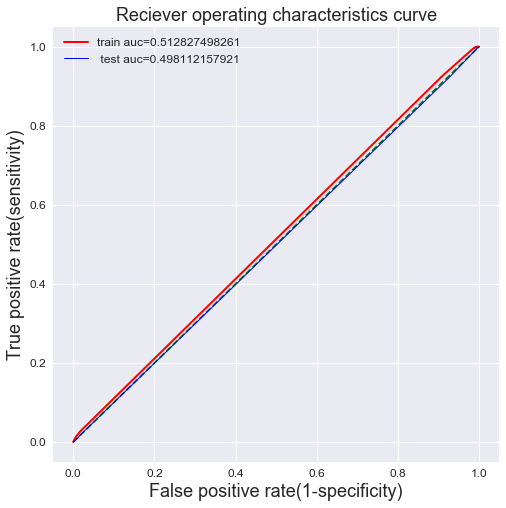

**************************************

scores on test data are:

precison score is 0.8412014299555645

recall_score is 0.9977016959898558

f1 score is 0.9127920677216452

****************************************************************

Confusin matrix on train data


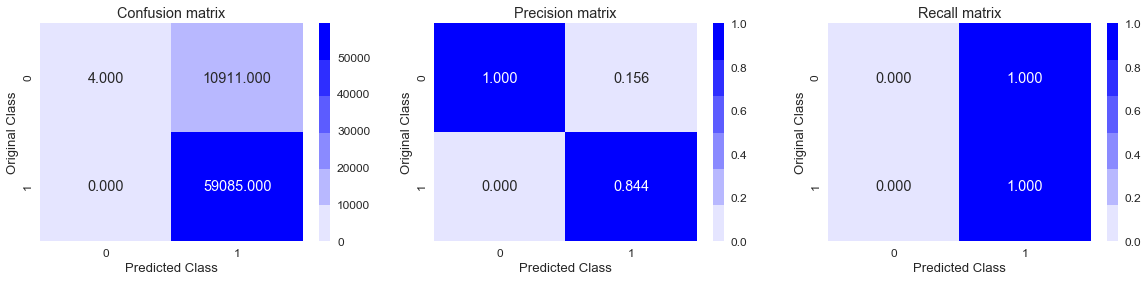

Confusion matrix for test data


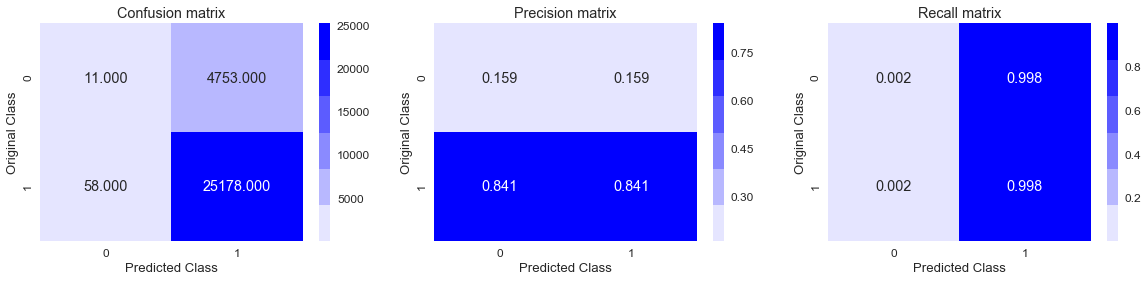

In [46]:
'''AUC ON TEST DATA'''
train_auc_tfidfw2v_gb,test_auc_tfidfw2v_gb,train_pred_proba,test_pred_proba,train_pred,test_pred = auc(best_depth_tfidfw2v_gb,
    best_n_tfidfw2v_gb,np.array(train_tfidfw2v),test_tfidfw2v)

'''PLOTTING THE ROC CURVE'''
curve(train_pred_proba,test_pred_proba)

'''Precision,recall and f1 score'''
metrics(test_pred)


'''Plotting the confusion matrix'''
print('Confusin matrix on train data')
plot_confusion_matrix(Y_train,train_pred)
print('Confusion matrix for test data')
plot_confusion_matrix(Y_test,test_pred)

# [7] Conclusions

In [85]:
#create table using prettytable
from prettytable import PrettyTable 

#table for random forest
table_rf = PrettyTable()
no = [1,2,3,4]
vectorizers = ['Bag of vectors','TFIDF','Average Word 2 vector','TFIDF Word 2 vector']#all vectorizers
depths = ['50','50','15','50']#best parameters
estimators = ['450','250','250','450']
AUC = ['0.501','0.495','0.903','0.883']#their respective auc scores

table_rf.add_column("SNo",no)
table_rf.add_column('Vectorizers',vectorizers)
table_rf.add_column('max depth',depths)
table_rf.add_column('no. of estimators',estimators)
table_rf.add_column('AUC on test',AUC)
print('\t\t\t\t Table for Random Forest')
print(table_rf)
print('\n\n\n')


table_gb = PrettyTable()

no_gb = [1,2,3,4]
vectorizers_gb = ['Bag of vectors','TFIDF','Average Word 2 vector','TFIDF Word 2 vector']#all vectorizers
depths_gb = ['3','3','3','3']
estimators_gb = ['100','200','50','10']
AUC_gb = ['0.5008','0.4984','0.5021','0.4981']

table_gb.add_column("SNo",no_gb)
table_gb.add_column('Vectorizers',vectorizers_gb)
table_gb.add_column('max depth',depths_gb)
table_gb.add_column('no. of estimators',estimators_gb)
table_gb.add_column('AUC on test for GBDT',AUC_gb)
print('\t\t\t\t Table for GBDT using XGBoost')
print(table_gb)




				 Table for Random Forest
+-----+-----------------------+-----------+-------------------+-------------+
| SNo |      Vectorizers      | max depth | no. of estimators | AUC on test |
+-----+-----------------------+-----------+-------------------+-------------+
|  1  |     Bag of vectors    |     50    |        450        |    0.501    |
|  2  |         TFIDF         |     50    |        250        |    0.495    |
|  3  | Average Word 2 vector |     15    |        250        |    0.903    |
|  4  |  TFIDF Word 2 vector  |     50    |        450        |    0.883    |
+-----+-----------------------+-----------+-------------------+-------------+




				 Table for GBDT using XGBoost
+-----+-----------------------+-----------+-------------------+----------------------+
| SNo |      Vectorizers      | max depth | no. of estimators | AUC on test for GBDT |
+-----+-----------------------+-----------+-------------------+----------------------+
|  1  |     Bag of vectors    |     3     |     